In [1]:
import numpy as np
import pandas as pd
import matplotlib. pyplot as plt

from textblob import TextBlob
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler,StandardScaler

from keras.layers import LSTM, Dense, Dropout

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential

import warnings 
warnings.filterwarnings('ignore')

In [2]:
df2=pd.read_csv(r"C:\Users\Priyanshul\OneDrive\Desktop\Hackathon\stock-market-prediction-and-sentimental-analysis\update_data.csv",index_col='Date',parse_dates=True,infer_datetime_format=True)
df1 = pd.read_csv(r"C:\Users\Priyanshul\OneDrive\Desktop\Hackathon\stock-market-prediction-and-sentimental-analysis\updated1.csv\Combined_News_DJIA(train).csv",parse_dates=True,infer_datetime_format=True)

In [3]:
df1.loc[:, 'Date'] = pd.to_datetime(df1['Date'])
merge=df1.merge(df2,how='inner',on='Date')

In [4]:
headlines = []

for row in range(0,len(merge.index)):
    headlines.append(' '.join( str(x) for x in merge.iloc[row,2:27]))

In [5]:
clean_headlines = []

for i in range(0,len(headlines)):
    clean_headlines.append(re.sub("b[(')]",' ',headlines[i]))
    clean_headlines[i]= re.sub('b[(")]',' ',clean_headlines[i])
    clean_headlines[i]= re.sub("\'",' ',clean_headlines[i])

In [6]:
merge['Combined_news']=clean_headlines

In [7]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [8]:
merge['Subjectivity']=merge['Combined_news'].apply(getSubjectivity)
merge['Polarity']=merge['Combined_news'].apply(getPolarity)

In [9]:
def getSIA(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment

In [10]:
compound = []
neg = []
pos = []
neu = []
SIA=0

for i in range(0,len(merge['Combined_news'])):
    SIA = getSIA(merge['Combined_news'][i])
    compound.append(SIA['compound'])
    neg.append(SIA['neg'])
    pos.append(SIA['pos'])
    neu.append(SIA['neu'])

In [11]:
merge['Compound']=compound
merge['Negative']=neg
merge['Positive']=pos
merge['Neutral']=neu

In [12]:
df_final = merge[['Date','Open','High','Low','Close','Volume','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df_final

,Date,Open,High,Low,Close,Volume,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2008-08-08,11432.08984,11759.95996,11388.04004,11734.32031,212830000,0.267549,-0.048568,-0.9982,0.233,0.726,0.041
1,2008-08-11,11729.66992,11867.11035,11675.53027,11782.34961,183190000,0.374806,0.121956,-0.9858,0.188,0.724,0.088
2,2008-08-12,11781.70020,11782.34961,11601.51953,11642.46973,173590000,0.518785,-0.046530,-0.9715,0.126,0.819,0.055
3,2008-08-13,11632.80957,11633.78027,11453.33984,11532.95996,182550000,0.364021,0.011398,-0.9809,0.143,0.793,0.064
4,2008-08-14,11532.07031,11718.28027,11450.88965,11615.92969,159790000,0.375099,0.040677,-0.9882,0.188,0.719,0.093
...,...,...,...,...,...,...,...,...,...,...,...,...
1858,2015-12-24,17593.25977,17606.33984,17543.94922,17552.16992,40350000,0.317617,0.052091,-0.9966,0.158,0.803,0.039
1859,2015-12-28,17535.66016,17536.90039,17437.33984,17528.26953,59770000,0.284549,-0.030512,-0.9944,0.144,0.830,0.026
1860,2015-12-29,17547.36914,17750.01953,17547.36914,17720.98047,69860000,0.359273,0.101038,-0.9920,0.143,0.817,0.039
1861,2015-12-30,17711.93945,17714.13086,17588.86914,17603.86914,59760000,0.334222,-0.010854,-0.9917,0.189,0.724,0.087


In [13]:
data=df_final[['Date','Open','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
data.index=data['Date']
data.drop('Date', axis=1, inplace=True)
data['Close']=df_final['Close'].values
data

,Open,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Close
Date,,,,,,,,
2008-08-08,11432.08984,0.267549,-0.048568,-0.9982,0.233,0.726,0.041,11734.32031
2008-08-11,11729.66992,0.374806,0.121956,-0.9858,0.188,0.724,0.088,11782.34961
2008-08-12,11781.70020,0.518785,-0.046530,-0.9715,0.126,0.819,0.055,11642.46973
2008-08-13,11632.80957,0.364021,0.011398,-0.9809,0.143,0.793,0.064,11532.95996
2008-08-14,11532.07031,0.375099,0.040677,-0.9882,0.188,0.719,0.093,11615.92969
...,...,...,...,...,...,...,...,...
2015-12-24,17593.25977,0.317617,0.052091,-0.9966,0.158,0.803,0.039,17552.16992
2015-12-28,17535.66016,0.284549,-0.030512,-0.9944,0.144,0.830,0.026,17528.26953
2015-12-29,17547.36914,0.359273,0.101038,-0.9920,0.143,0.817,0.039,17720.98047


In [14]:
dataset = data.values

train = dataset[0:1400,:]
valid = dataset[1400:,7]

In [15]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(dataset[i-60:i,0:7])
    y_train.append(dataset[i,7])
x_train, y_train = np.array(x_train), np.array(y_train)

In [16]:
y_train = y_train.reshape(-1,1)
y_train.shape

(1340, 1)

In [17]:
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))

x = scaler1.fit_transform(x_train[:,:,0])
y_train = scaler2.fit_transform(y_train)

In [18]:
x = x.reshape(1340,60,1)
x.shape

(1340, 60, 1)

In [19]:
x_dummy=x_train[:,:,1:7]

In [20]:
result = np.concatenate((x,x_dummy), axis=2)

In [21]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],7)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(result, y_train, epochs=10, batch_size=1, verbose=1)

Epoch 1/10
1340/1340 [==============================] - 63s 41ms/step - loss: 0.0041
Epoch 2/10
1340/1340 [==============================] - 58s 44ms/step - loss: 0.0012
Epoch 3/10
1340/1340 [==============================] - 60s 45ms/step - loss: 9.9984e-04
Epoch 4/10
1340/1340 [==============================] - 60s 45ms/step - loss: 0.0010
Epoch 5/10
1340/1340 [==============================] - 63s 47ms/step - loss: 6.7181e-04
Epoch 6/10
1340/1340 [==============================] - 64s 47ms/step - loss: 6.7665e-04
Epoch 7/10
1340/1340 [==============================] - 64s 48ms/step - loss: 5.7691e-04
Epoch 8/10
1340/1340 [==============================] - 64s 48ms/step - loss: 5.9859e-04
Epoch 9/10
1340/1340 [==============================] - 57s 43ms/step - loss: 5.4845e-04
Epoch 10/10
1340/1340 [==============================] - 59s 44ms/step - loss: 4.9152e-04


In [22]:
from tensorflow.keras.models import load_model, save_model
model.save("Stocks.h5")

In [23]:
inputs=dataset[len(data) - len(valid) - 60:,]
inputs.shape

(523, 8)

In [24]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0:7])
X_test = np.array(X_test)

In [25]:
inputs  = scaler1.transform(X_test[:,:,0])

In [26]:
inputs= inputs.reshape(463,60,1)
inputs.shape

(463, 60, 1)

In [27]:
test_dummy=X_test[:,:,1:7]
inputs = np.concatenate((inputs,test_dummy), axis=2)

In [28]:
closing_price = model.predict(inputs)

15/15 [==============================] - 4s 28ms/step


In [29]:
closing_price = scaler2.inverse_transform(closing_price)

In [30]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

866.9135089894688

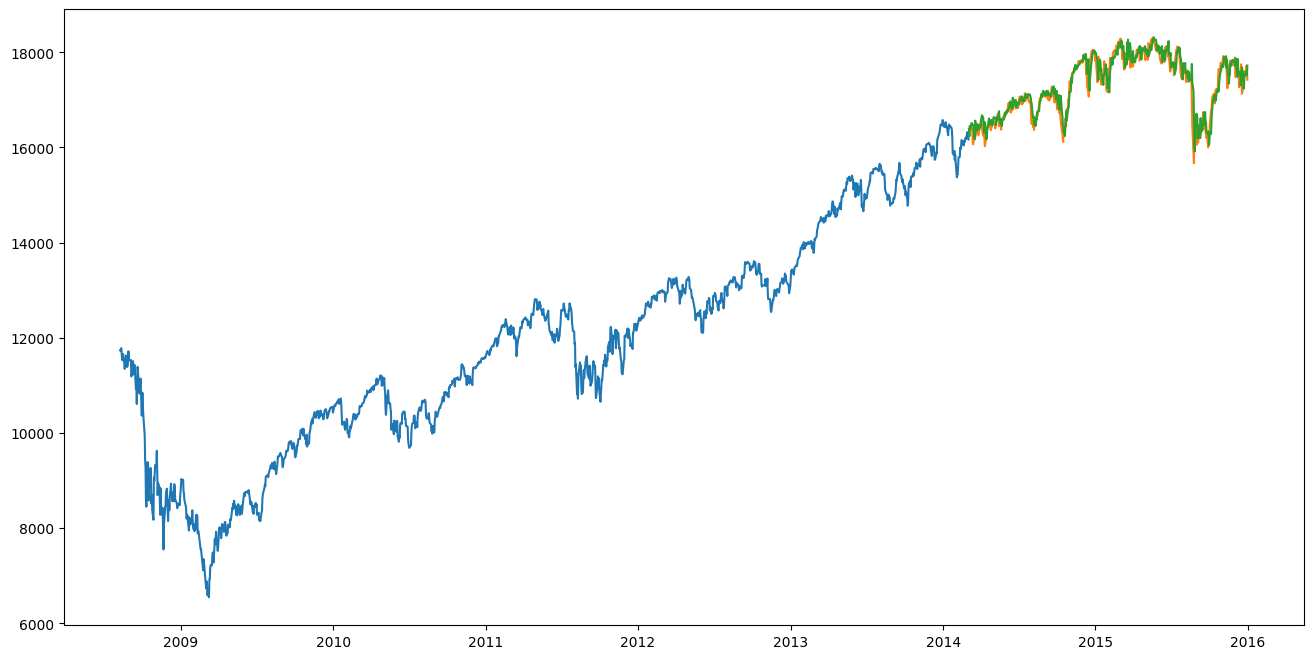

In [31]:
train = data[:1400]
valid = data[1400:]
valid['Predictions'] = closing_price
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

In [34]:
data.head()

,Open,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Close
Date,,,,,,,,
2008-08-08,11432.08984,0.267549,-0.048568,-0.9982,0.233,0.726,0.041,11734.32031
2008-08-11,11729.66992,0.374806,0.121956,-0.9858,0.188,0.724,0.088,11782.34961
2008-08-12,11781.70020,0.518785,-0.046530,-0.9715,0.126,0.819,0.055,11642.46973
2008-08-13,11632.80957,0.364021,0.011398,-0.9809,0.143,0.793,0.064,11532.95996
2008-08-14,11532.07031,0.375099,0.040677,-0.9882,0.188,0.719,0.093,11615.92969


In [37]:
data.to_csv(r"C:\Users\Priyanshul\OneDrive\Desktop\Trading Bot\INFO.csv", index=True)

In [40]:
import pickle
with open(r"C:\Users\Priyanshul\OneDrive\Desktop\Trading Bot\scaler1.pkl", "wb") as f:
    pickle.dump(scaler1, f)

In [41]:
with open(r"C:\Users\Priyanshul\OneDrive\Desktop\Trading Bot\scaler2.pkl", "wb") as f:
    pickle.dump(scaler2, f)